<a href="https://colab.research.google.com/github/Nichal9651/Capstone-project/blob/main/Copy_of_Finetuning_2_Accuracy_75_89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ============================================================================
# SKIN LESION DESCRIPTION GENERATOR - GOOGLE COLAB
# Generates domain-specific medical descriptions for ISIC dataset
# ============================================================================

# ===== CELL 1: INSTALLATION =====
"""
Run this first!
!pip install -q kagglehub transformers torch torchvision pillow pandas scikit-learn tqdm accelerate
"""

# ===== CELL 2: IMPORTS =====

import os
import kagglehub
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import Blip2Processor, Blip2ForConditionalGeneration
from PIL import Image
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from pathlib import Path
import json
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# ===== CELL 3: DOWNLOAD & SETUP DATASET =====

def setup_isic_dataset():
    """
    Download ISIC dataset and explore structure
    """
    print("📥 Downloading ISIC Skin Cancer Dataset...")
    kaggle_root = kagglehub.dataset_download('nodoubttome/skin-cancer9-classesisic')

    DATA_ROOT = os.path.join(
        kaggle_root,
        "Skin cancer ISIC The International Skin Imaging Collaboration",
        "Train"
    )

    print(f"✅ Dataset downloaded to: {DATA_ROOT}")

    # List all classes
    classes = sorted([d for d in os.listdir(DATA_ROOT)
                     if os.path.isdir(os.path.join(DATA_ROOT, d))])

    print(f"\n📊 Found {len(classes)} classes:")
    for i, cls in enumerate(classes, 1):
        class_path = os.path.join(DATA_ROOT, cls)
        count = len([f for f in os.listdir(class_path)
                    if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        print(f"  {i}. {cls}: {count} images")

    return DATA_ROOT, classes


def create_dataset_index(DATA_ROOT, classes):
    """
    Create index of all images with paths and labels
    """
    print("\n📝 Creating dataset index...")

    data = []
    for cls in tqdm(classes, desc="Scanning directories"):
        class_dir = os.path.join(DATA_ROOT, cls)
        images = [f for f in os.listdir(class_dir)
                 if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        for img in images:
            data.append({
                'image_name': img,
                'relative_path': os.path.join(cls, img),
                'full_path': os.path.join(class_dir, img),
                'label': cls
            })

    df = pd.DataFrame(data)
    print(f"✅ Total images: {len(df)}")

    # Create train/val/test splits
    train_df, temp_df = train_test_split(
        df, test_size=0.3, stratify=df['label'], random_state=42
    )
    val_df, test_df = train_test_split(
        temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42
    )

    print(f"\n📊 Dataset splits:")
    print(f"  Training:   {len(train_df)} images")
    print(f"  Validation: {len(val_df)} images")
    print(f"  Test:       {len(test_df)} images")

    # Save to CSV
    train_df.to_csv('train_index.csv', index=False)
    val_df.to_csv('val_index.csv', index=False)
    test_df.to_csv('test_index.csv', index=False)

    return train_df, val_df, test_df


# Run setup
DATA_ROOT, classes = setup_isic_dataset()
train_df, val_df, test_df = create_dataset_index(DATA_ROOT, classes)

# ===== CELL 4: DOMAIN-SPECIFIC DESCRIPTION TEMPLATES =====

class DermatologyDescriptionGenerator:
    """
    Generates medical descriptions based on dermatological knowledge
    Uses ABCDE criteria and clinical features
    """

    def __init__(self):
        # Comprehensive medical templates for each condition
        self.templates = {
            'actinic keratosis': {
                'description': 'A rough, scaly patch on chronically sun-exposed skin. The lesion displays a sandpaper-like texture with adherent scale. Color varies from erythematous pink to tan-brown. The surface is keratotic with possible surrounding solar elastosis.',
                'abcde': {
                    'asymmetry': 'Generally symmetric in configuration',
                    'border': 'Ill-defined borders blending with surrounding sun-damaged skin',
                    'color': 'Pink to red, sometimes brown, with overlying white or yellow scale',
                    'diameter': 'Typically small, ranging from 2-6mm, may coalesce into larger patches',
                    'evolution': 'Slowly progressive, may develop multiple lesions over time'
                },
                'features': [
                    'rough, dry, scaly surface texture',
                    'erythematous base with adherent keratotic scale',
                    'sandpaper-like feel on palpation',
                    'located on sun-exposed areas (face, scalp, forearms)',
                    'surrounding skin shows signs of chronic sun damage'
                ],
                'risk': 'Precancerous lesion with 5-10% risk of progression to SCC'
            },

            'basal cell carcinoma': {
                'description': 'A translucent, pearly nodule with visible telangiectasias. The lesion exhibits a rolled border with central depression. Surface appears shiny with a waxy quality. May show ulceration or crusting in advanced cases.',
                'abcde': {
                    'asymmetry': 'May show asymmetric growth pattern',
                    'border': 'Rolled, elevated, pearly borders with distinct margin',
                    'color': 'Translucent, pearly white, pink, or flesh-colored with telangiectasias',
                    'diameter': 'Variable size, often 5-10mm, slow-growing',
                    'evolution': 'Slowly progressive over months to years, rarely metastasizes'
                },
                'features': [
                    'pearly, translucent appearance',
                    'prominent telangiectatic vessels visible on surface',
                    'rolled or raised borders',
                    'central depression or ulceration (rodent ulcer)',
                    'firm consistency on palpation'
                ],
                'risk': 'Malignant but rarely metastasizes, locally destructive if untreated'
            },

            'dermatofibroma': {
                'description': 'A firm, dome-shaped dermal nodule with brown pigmentation. The lesion is well-circumscribed and indurated. Exhibits positive dimple sign when lateral pressure applied. Surface may show slight scale or be smooth.',
                'abcde': {
                    'asymmetry': 'Symmetric, round to oval configuration',
                    'border': 'Well-defined, distinct borders',
                    'color': 'Brown, tan, or reddish-brown, uniform pigmentation',
                    'diameter': 'Small, typically 5-10mm, stable in size',
                    'evolution': 'Stable, non-progressive, may persist indefinitely'
                },
                'features': [
                    'firm, hard consistency (fibrotic)',
                    'dome-shaped or slightly elevated',
                    'positive dimple sign (pathognomonic)',
                    'brown to reddish-brown coloration',
                    'fixed to dermis but mobile over underlying tissue'
                ],
                'risk': 'Benign fibrous histiocytoma, no malignant potential'
            },

            'melanoma': {
                'description': 'A pigmented lesion exhibiting multiple concerning features. Marked asymmetry with irregular, notched borders. Variegated coloration with shades of black, brown, red, white, and blue. Surface may be flat or elevated with irregular topography.',
                'abcde': {
                    'asymmetry': 'Pronounced asymmetry - one half distinctly different from the other',
                    'border': 'Irregular, notched, scalloped, or poorly defined borders',
                    'color': 'Multiple colors: black, brown, tan, red, white, blue, or depigmented areas',
                    'diameter': 'Often greater than 6mm (pencil eraser), but can be smaller',
                    'evolution': 'Changing size, shape, color, or symptoms (itching, bleeding)'
                },
                'features': [
                    'markedly asymmetric configuration',
                    'irregular, notched borders with geographic appearance',
                    'striking color variation within single lesion',
                    'may show regression (white areas) or inflammation (red areas)',
                    'surface may be ulcerated or bleeding in advanced cases'
                ],
                'risk': 'High-grade malignancy with significant metastatic potential - urgent evaluation required'
            },

            'nevus': {
                'description': 'A symmetric, uniformly pigmented lesion with regular borders. The nevus displays homogeneous color throughout, typically brown. Surface is smooth or slightly elevated. Overall appearance is bland and benign.',
                'abcde': {
                    'asymmetry': 'Symmetric - mirror image on both halves',
                    'border': 'Regular, smooth, well-circumscribed borders',
                    'color': 'Uniform color - single shade of tan, brown, or black',
                    'diameter': 'Stable size, typically less than 6mm',
                    'evolution': 'Stable over time, minimal to no changes'
                },
                'features': [
                    'symmetric round or oval shape',
                    'regular, well-defined borders',
                    'uniform tan to brown pigmentation',
                    'smooth surface, may be flat or slightly raised',
                    'stable appearance over time'
                ],
                'risk': 'Benign melanocytic nevus - routine monitoring sufficient'
            },

            'pigmented benign keratosis': {
                'description': 'A warty, stuck-on appearing lesion with well-demarcated borders. The keratosis has a cerebriform or verrucous surface. Pigmentation is uniform tan to dark brown. May contain keratin-filled cysts (horn cysts) visible on close inspection.',
                'abcde': {
                    'asymmetry': 'Generally symmetric with regular contours',
                    'border': 'Sharp, well-demarcated, appear "stuck-on" to skin',
                    'color': 'Tan, brown, or black - uniform pigmentation',
                    'diameter': 'Variable, 3-30mm, stable or slowly enlarging',
                    'evolution': 'Slowly progressive, stable once established'
                },
                'features': [
                    'stuck-on, waxy appearance',
                    'verrucous or cerebriform surface texture',
                    'sharply demarcated borders',
                    'horn cysts (keratin plugs) may be visible',
                    'uniform tan to brown pigmentation'
                ],
                'risk': 'Benign seborrheic keratosis - no malignant transformation risk'
            },

            'seborrheic keratosis': {
                'description': 'A benign, well-circumscribed lesion with a waxy, “stuck-on” appearance. The surface is verrucous or cerebriform with possible keratin plugs. Color ranges from light tan to dark brown or black. Common in older adults on the trunk, face, and extremities.',
                'abcde': {
                    'asymmetry': 'Usually symmetric in shape',
                    'border': 'Sharply demarcated, regular borders with a stuck-on appearance',
                    'color': 'Uniform tan, brown, or black pigmentation',
                    'diameter': 'Variable (3–30mm), may enlarge slowly',
                    'evolution': 'Stable or slowly enlarging, no malignant transformation'
                },
                'features': [
                    'stuck-on, waxy surface',
                    'verrucous or cerebriform texture',
                    'well-defined borders',
                    'presence of keratin plugs or horn cysts',
                    'common on sun-exposed areas in elderly individuals'
                ],
                'risk': 'Benign epidermal tumor (seborrheic keratosis) with no malignant potential'
            },

            'squamous cell carcinoma': {
                'description': 'A firm, indurated erythematous nodule or plaque with rough surface. The lesion exhibits hyperkeratosis with possible ulceration. Borders are ill-defined with induration extending beyond visible margin. Surface may be crusted or bleeding.',
                'abcde': {
                    'asymmetry': 'Asymmetric with irregular growth pattern',
                    'border': 'Ill-defined, irregular borders with induration',
                    'color': 'Red, pink, or erythematous with possible pigmentation',
                    'diameter': 'Variable, often 1-2cm, progressively enlarging',
                    'evolution': 'Rapid growth over weeks to months, may ulcerate or bleed'
                },
                'features': [
                    'firm, indurated consistency',
                    'rough, hyperkeratotic surface',
                    'erythematous to pink coloration',
                    'may show ulceration, crusting, or bleeding',
                    'palpable induration extends beyond visible lesion'
                ],
                'risk': 'Malignant with metastatic potential (2-5%), requires prompt treatment'
            },

            'vascular lesion': {
                'description': 'A lesion of vascular origin displaying red to purple coloration. Blanches partially or completely with pressure (diascopy positive). May be flat (macular) or raised (papular). Surface is smooth without scale.',
                'abcde': {
                    'asymmetry': 'Variable - may be symmetric or asymmetric',
                    'border': 'Well-defined or irregular depending on type',
                    'color': 'Red, purple, or violaceous - blanches with pressure',
                    'diameter': 'Highly variable, from pinpoint to several centimeters',
                    'evolution': 'Variable - some stable, others progressive'
                },
                'features': [
                    'red, purple, or violaceous coloration',
                    'blanches with direct pressure (diascopy)',
                    'may be flat (hemangioma) or raised (pyogenic granuloma)',
                    'smooth surface without scale',
                    'may show clustered or linear configuration'
                ],
                'risk': 'Typically benign vascular proliferation or malformation'
            }
        }

    def generate_description(self, label):
        """
        Generate comprehensive medical description
        """
        label_key = label.lower()

        if label_key not in self.templates:
            # Fallback for unknown labels
            return {
                'full_description': f'A skin lesion classified as {label}. Detailed dermatological examination required.',
                'abcde_analysis': 'Complete clinical assessment needed',
                'clinical_features': 'Requires professional evaluation',
                'risk_assessment': 'Consult dermatologist for proper diagnosis'
            }

        template = self.templates[label_key]

        # Build structured description
        description = {
            'label': label,
            'full_description': template['description'],
            'abcde_asymmetry': template['abcde']['asymmetry'],
            'abcde_border': template['abcde']['border'],
            'abcde_color': template['abcde']['color'],
            'abcde_diameter': template['abcde']['diameter'],
            'abcde_evolution': template['abcde']['evolution'],
            'clinical_features': ' | '.join(template['features']),
            'risk_assessment': template['risk']
        }

        # Create comprehensive text version
        abcde_text = f"ABCDE Analysis: Asymmetry - {template['abcde']['asymmetry']}. Border - {template['abcde']['border']}. Color - {template['abcde']['color']}. Diameter - {template['abcde']['diameter']}. Evolution - {template['abcde']['evolution']}."

        description['comprehensive_description'] = f"{template['description']} {abcde_text} Clinical features include: {'; '.join(template['features'])}. {template['risk']}"

        return description

def generate_descriptions_for_dataset(df, output_csv):
    """
    Generate domain-specific descriptions for entire dataset
    """
    print(f"\n🔬 Generating medical descriptions for {len(df)} images...")

    generator = DermatologyDescriptionGenerator()
    descriptions = []

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing"):
        desc = generator.generate_description(row['label'])
        descriptions.append({
            'image_name': row['image_name'],
            'relative_path': row['relative_path'],
            'full_path': row['full_path'],
            'label': row['label'],
            'full_description': desc['full_description'],
            'abcde_asymmetry': desc['abcde_asymmetry'],
            'abcde_border': desc['abcde_border'],
            'abcde_color': desc['abcde_color'],
            'abcde_diameter': desc['abcde_diameter'],
            'abcde_evolution': desc['abcde_evolution'],
            'clinical_features': desc['clinical_features'],
            'risk_assessment': desc['risk_assessment'],
            'comprehensive_description': desc['comprehensive_description']
        })

    # Save to CSV
    desc_df = pd.DataFrame(descriptions)
    desc_df.to_csv(output_csv, index=False)

    print(f"✅ Descriptions saved to: {output_csv}")
    print(f"\n📊 Sample description:")
    sample = desc_df.iloc[0]
    print(f"Label: {sample['label']}")
    print(f"Description: {sample['full_description'][:200]}...")

    return desc_df


# Generate descriptions for all splits
train_descriptions = generate_descriptions_for_dataset(train_df, 'train_descriptions.csv')
val_descriptions = generate_descriptions_for_dataset(val_df, 'val_descriptions.csv')
test_descriptions = generate_descriptions_for_dataset(test_df, 'test_descriptions.csv')

# ===== CELL 6: VISUAL FEATURE ENHANCEMENT (OPTIONAL) =====

class VisualDescriptionEnhancer:
    """
    Uses BLIP-2 to extract visual features from images
    Enhances template descriptions with actual visual analysis
    """

    def __init__(self, model_name="Salesforce/blip2-opt-2.7b"):
        print(f"\n🤖 Loading BLIP-2 model: {model_name}")
        print("⚠️ This requires GPU and ~8GB VRAM")

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

        self.processor = Blip2Processor.from_pretrained(model_name)
        self.model = Blip2ForConditionalGeneration.from_pretrained(
            model_name,
            torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
            device_map="auto"
        )

        print("✅ Model loaded successfully")

    def analyze_image(self, image_path):
        """
        Extract visual features from skin lesion image
        """
        try:
            image = Image.open(image_path).convert('RGB')

            # Dermatology-specific prompt
            prompt = "Question: Describe this skin lesion focusing on color, texture, border characteristics, and symmetry. Answer:"

            inputs = self.processor(image, prompt, return_tensors="pt").to(self.device, torch.float16)

            with torch.no_grad():
                outputs = self.model.generate(
                    **inputs,
                    max_new_tokens=100,
                    num_beams=5,
                    temperature=0.7
                )

            visual_desc = self.processor.decode(outputs[0], skip_special_tokens=True)
            return visual_desc

        except Exception as e:
            print(f"Error analyzing {image_path}: {str(e)}")
            return ""

    def enhance_dataset_descriptions(self, desc_df, output_csv, max_samples=None):
        """
        Enhance descriptions with visual analysis
        """
        print(f"\n👁️ Enhancing descriptions with visual analysis...")

        if max_samples:
            print(f"Processing {max_samples} samples (set max_samples=None for all)")
            desc_df = desc_df.head(max_samples)

        enhanced_data = []

        for idx, row in tqdm(desc_df.iterrows(), total=len(desc_df), desc="Analyzing images"):
            visual_analysis = self.analyze_image(row['full_path'])

            # Combine template and visual descriptions
            enhanced_desc = f"{row['comprehensive_description']}\n\nVisual Analysis: {visual_analysis}"

            enhanced_data.append({
                **row.to_dict(),
                'visual_analysis': visual_analysis,
                'enhanced_description': enhanced_desc
            })

        enhanced_df = pd.DataFrame(enhanced_data)
        enhanced_df.to_csv(output_csv, index=False)

        print(f"✅ Enhanced descriptions saved to: {output_csv}")
        return enhanced_df


# ===== CELL 7: OPTIONAL - ENHANCE WITH VISUAL ANALYSIS =====

# Uncomment to use visual enhancement (requires GPU memory)
"""
enhancer = VisualDescriptionEnhancer()

# Enhance test set (limit to 100 samples for demo)
test_enhanced = enhancer.enhance_dataset_descriptions(
    test_descriptions,
    'test_enhanced_descriptions.csv',
    max_samples=100
)

print("\n📊 Sample enhanced description:")
sample = test_enhanced.iloc[0]
print(f"Label: {sample['label']}")
print(f"Enhanced: {sample['enhanced_description'][:300]}...")
"""

# ===== CELL 8: VIEW SAMPLE RESULTS =====

def display_sample_descriptions(desc_df, n_samples=3):
    """
    Display sample descriptions for inspection
    """
    print("\n" + "="*80)
    print("📋 SAMPLE DESCRIPTIONS")
    print("="*80)

    for idx in range(min(n_samples, len(desc_df))):
        row = desc_df.iloc[idx]
        print(f"\n{'─'*80}")
        print(f"🏷️  Label: {row['label']}")
        print(f"📸 Image: {row['image_name']}")
        print(f"\n📝 Description:")
        print(f"   {row['full_description']}")
        print(f"\n🔍 ABCDE Analysis:")
        print(f"   • Asymmetry: {row['abcde_asymmetry']}")
        print(f"   • Border: {row['abcde_border']}")
        print(f"   • Color: {row['abcde_color']}")
        print(f"   • Diameter: {row['abcde_diameter']}")
        print(f"   • Evolution: {row['abcde_evolution']}")
        print(f"\n⚕️  Risk: {row['risk_assessment']}")
        print(f"{'─'*80}")


# Display samples from each split
print("\n🔍 TRAINING SET SAMPLES:")
display_sample_descriptions(train_descriptions, n_samples=2)

print("\n🔍 TEST SET SAMPLES:")
display_sample_descriptions(test_descriptions, n_samples=2)

# ===== CELL 9: STATISTICS & SUMMARY =====

def generate_summary_statistics(train_desc, val_desc, test_desc):
    """
    Generate summary statistics of the dataset
    """
    print("\n" + "="*80)
    print("📊 DATASET SUMMARY")
    print("="*80)

    all_data = pd.concat([train_desc, val_desc, test_desc])

    print(f"\n📈 Total Dataset:")
    print(f"   Total images: {len(all_data)}")
    print(f"   Classes: {len(all_data['label'].unique())}")

    print(f"\n📊 Class Distribution:")
    class_counts = all_data['label'].value_counts()
    for label, count in class_counts.items():
        percentage = (count / len(all_data)) * 100
        print(f"   {label:30s}: {count:5d} ({percentage:5.2f}%)")

    print(f"\n📦 Split Sizes:")
    print(f"   Training:   {len(train_desc):5d} images")
    print(f"   Validation: {len(val_desc):5d} images")
    print(f"   Test:       {len(test_desc):5d} images")

    print(f"\n📄 Generated Files:")
    print(f"   ✓ train_descriptions.csv")
    print(f"   ✓ val_descriptions.csv")
    print(f"   ✓ test_descriptions.csv")

    print("\n" + "="*80)
    print("✅ DESCRIPTION GENERATION COMPLETE!")
    print("="*80)
    print("\n💡 Next steps:")
    print("   1. Review sample descriptions above")
    print("   2. Optional: Run visual enhancement (Cell 7)")
    print("   3. Use descriptions as input for LLM classification")
    print("   4. Download CSV files for further processing")


generate_summary_statistics(train_descriptions, val_descriptions, test_descriptions)

# ===== CELL 10: EXPORT & DOWNLOAD =====

print("\n📥 Files ready for download:")
print("   • train_descriptions.csv")
print("   • val_descriptions.csv")
print("   • test_descriptions.csv")
print("\nUse Colab's file browser (left sidebar) to download these files.")


PyTorch version: 2.8.0+cu126
CUDA available: True
📥 Downloading ISIC Skin Cancer Dataset...
Using Colab cache for faster access to the 'skin-cancer9-classesisic' dataset.
✅ Dataset downloaded to: /kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Train

📊 Found 9 classes:
  1. actinic keratosis: 114 images
  2. basal cell carcinoma: 376 images
  3. dermatofibroma: 95 images
  4. melanoma: 438 images
  5. nevus: 357 images
  6. pigmented benign keratosis: 462 images
  7. seborrheic keratosis: 77 images
  8. squamous cell carcinoma: 181 images
  9. vascular lesion: 139 images

📝 Creating dataset index...


Scanning directories:   0%|          | 0/9 [00:00<?, ?it/s]

✅ Total images: 2239

📊 Dataset splits:
  Training:   1567 images
  Validation: 336 images
  Test:       336 images

🔬 Generating medical descriptions for 1567 images...


Processing:   0%|          | 0/1567 [00:00<?, ?it/s]

✅ Descriptions saved to: train_descriptions.csv

📊 Sample description:
Label: melanoma
Description: A pigmented lesion exhibiting multiple concerning features. Marked asymmetry with irregular, notched borders. Variegated coloration with shades of black, brown, red, white, and blue. Surface may be fl...

🔬 Generating medical descriptions for 336 images...


Processing:   0%|          | 0/336 [00:00<?, ?it/s]

✅ Descriptions saved to: val_descriptions.csv

📊 Sample description:
Label: melanoma
Description: A pigmented lesion exhibiting multiple concerning features. Marked asymmetry with irregular, notched borders. Variegated coloration with shades of black, brown, red, white, and blue. Surface may be fl...

🔬 Generating medical descriptions for 336 images...


Processing:   0%|          | 0/336 [00:00<?, ?it/s]

✅ Descriptions saved to: test_descriptions.csv

📊 Sample description:
Label: basal cell carcinoma
Description: A translucent, pearly nodule with visible telangiectasias. The lesion exhibits a rolled border with central depression. Surface appears shiny with a waxy quality. May show ulceration or crusting in ad...

🔍 TRAINING SET SAMPLES:

📋 SAMPLE DESCRIPTIONS

────────────────────────────────────────────────────────────────────────────────
🏷️  Label: melanoma
📸 Image: ISIC_0000412.jpg

📝 Description:
   A pigmented lesion exhibiting multiple concerning features. Marked asymmetry with irregular, notched borders. Variegated coloration with shades of black, brown, red, white, and blue. Surface may be flat or elevated with irregular topography.

🔍 ABCDE Analysis:
   • Asymmetry: Pronounced asymmetry - one half distinctly different from the other
   • Border: Irregular, notched, scalloped, or poorly defined borders
   • Color: Multiple colors: black, brown, tan, red, white, blue, or depigm

In [ ]:
# ===== Safe inspection & save for train/val/test description DataFrames =====
import pandas as pd
from pathlib import Path
from IPython.display import display

# helper to get dataframe: prefer in-memory variable, else load csv, else None
def get_df(var_name, csv_name):
    # 1) try variable in globals()
    if var_name in globals():
        df = globals()[var_name]
        if isinstance(df, pd.DataFrame):
            return df
    # 2) try CSV file
    if Path(csv_name).exists():
        try:
            df = pd.read_csv(csv_name)
            print(f"Loaded '{csv_name}' from disk.")
            return df
        except Exception as e:
            print(f"Could not read {csv_name}: {e}")
    # 3) not found
    print(f"Warning: neither variable '{var_name}' nor file '{csv_name}' found.")
    return None

# load (or reuse) the dataframes
train_df = get_df("train_descriptions", "train_descriptions.csv")
val_df   = get_df("val_descriptions",   "val_descriptions.csv")
test_df  = get_df("test_descriptions",  "test_descriptions.csv")

def safe_show_and_save(df, name):
    if df is None:
        print(f"\n{name}: SKIPPED (no data)\n")
        return
    print(f"\n{name} set: {len(df)} rows")
    # prefer these columns if present
    preferred = ['image_name','relative_path','full_path','label',
                 'full_description','comprehensive_description','enhanced_description']
    present = [c for c in preferred if c in df.columns]
    # fallback: first 6 columns
    if not present:
        present = df.columns.tolist()[:6]
    print("Showing columns:", present)
    display(df[present].head(5))
    # save if no CSV exists (or overwrite if you prefer)
    out_csv = f"{name.lower()}_descriptions.csv"
    try:
        df.to_csv(out_csv, index=False)
        print(f"Saved: {out_csv}")
    except Exception as e:
        print(f"Could not save {out_csv}: {e}")

# show all three splits
safe_show_and_save(train_df, "Train")
safe_show_and_save(val_df,   "Validation")
safe_show_and_save(test_df,  "Test")

# class distribution for each split (safely)
def show_class_counts(df, name):
    if df is None:
        return
    if 'label' in df.columns:
        counts = df['label'].value_counts()
        print(f"\n{name} class distribution (top 10):")
        display(counts.head(20))
    else:
        print(f"\n{name} has no 'label' column.")

show_class_counts(train_df, "Train")
show_class_counts(val_df,   "Validation")
show_class_counts(test_df,  "Test")

print("\n✅ Done — inspect the printed samples and CSV files in your notebook file list.")



Train set: 1567 rows
Showing columns: ['image_name', 'relative_path', 'full_path', 'label', 'full_description', 'comprehensive_description']


,image_name,relative_path,full_path,label,full_description,comprehensive_description
0,ISIC_0000412.jpg,melanoma/ISIC_0000412.jpg,/kaggle/input/skin-cancer9-classesisic/Skin ca...,melanoma,A pigmented lesion exhibiting multiple concern...,A pigmented lesion exhibiting multiple concern...
1,ISIC_0027509.jpg,pigmented benign keratosis/ISIC_0027509.jpg,/kaggle/input/skin-cancer9-classesisic/Skin ca...,pigmented benign keratosis,"A warty, stuck-on appearing lesion with well-d...","A warty, stuck-on appearing lesion with well-d..."
2,ISIC_0027562.jpg,nevus/ISIC_0027562.jpg,/kaggle/input/skin-cancer9-classesisic/Skin ca...,nevus,"A symmetric, uniformly pigmented lesion with r...","A symmetric, uniformly pigmented lesion with r..."
3,ISIC_0025661.jpg,pigmented benign keratosis/ISIC_0025661.jpg,/kaggle/input/skin-cancer9-classesisic/Skin ca...,pigmented benign keratosis,"A warty, stuck-on appearing lesion with well-d...","A warty, stuck-on appearing lesion with well-d..."
4,ISIC_0033705.jpg,actinic keratosis/ISIC_0033705.jpg,/kaggle/input/skin-cancer9-classesisic/Skin ca...,actinic keratosis,"A rough, scaly patch on chronically sun-expose...","A rough, scaly patch on chronically sun-expose..."


Saved: train_descriptions.csv

Validation set: 336 rows
Showing columns: ['image_name', 'relative_path', 'full_path', 'label', 'full_description', 'comprehensive_description']


,image_name,relative_path,full_path,label,full_description,comprehensive_description
0,ISIC_0000487.jpg,melanoma/ISIC_0000487.jpg,/kaggle/input/skin-cancer9-classesisic/Skin ca...,melanoma,A pigmented lesion exhibiting multiple concern...,A pigmented lesion exhibiting multiple concern...
1,ISIC_0000504.jpg,nevus/ISIC_0000504.jpg,/kaggle/input/skin-cancer9-classesisic/Skin ca...,nevus,"A symmetric, uniformly pigmented lesion with r...","A symmetric, uniformly pigmented lesion with r..."
2,ISIC_0000064.jpg,nevus/ISIC_0000064.jpg,/kaggle/input/skin-cancer9-classesisic/Skin ca...,nevus,"A symmetric, uniformly pigmented lesion with r...","A symmetric, uniformly pigmented lesion with r..."
3,ISIC_0010872.jpg,seborrheic keratosis/ISIC_0010872.jpg,/kaggle/input/skin-cancer9-classesisic/Skin ca...,seborrheic keratosis,"A benign, well-circumscribed lesion with a wax...","A benign, well-circumscribed lesion with a wax..."
4,ISIC_0025454.jpg,pigmented benign keratosis/ISIC_0025454.jpg,/kaggle/input/skin-cancer9-classesisic/Skin ca...,pigmented benign keratosis,"A warty, stuck-on appearing lesion with well-d...","A warty, stuck-on appearing lesion with well-d..."


Saved: validation_descriptions.csv

Test set: 336 rows
Showing columns: ['image_name', 'relative_path', 'full_path', 'label', 'full_description', 'comprehensive_description']


,image_name,relative_path,full_path,label,full_description,comprehensive_description
0,ISIC_0026496.jpg,basal cell carcinoma/ISIC_0026496.jpg,/kaggle/input/skin-cancer9-classesisic/Skin ca...,basal cell carcinoma,"A translucent, pearly nodule with visible tela...","A translucent, pearly nodule with visible tela..."
1,ISIC_0011126.jpg,seborrheic keratosis/ISIC_0011126.jpg,/kaggle/input/skin-cancer9-classesisic/Skin ca...,seborrheic keratosis,"A benign, well-circumscribed lesion with a wax...","A benign, well-circumscribed lesion with a wax..."
2,ISIC_0026526.jpg,pigmented benign keratosis/ISIC_0026526.jpg,/kaggle/input/skin-cancer9-classesisic/Skin ca...,pigmented benign keratosis,"A warty, stuck-on appearing lesion with well-d...","A warty, stuck-on appearing lesion with well-d..."
3,ISIC_0010982.jpg,melanoma/ISIC_0010982.jpg,/kaggle/input/skin-cancer9-classesisic/Skin ca...,melanoma,A pigmented lesion exhibiting multiple concern...,A pigmented lesion exhibiting multiple concern...
4,ISIC_0000491.jpg,nevus/ISIC_0000491.jpg,/kaggle/input/skin-cancer9-classesisic/Skin ca...,nevus,"A symmetric, uniformly pigmented lesion with r...","A symmetric, uniformly pigmented lesion with r..."


Saved: test_descriptions.csv

Train class distribution (top 10):


,count
label,
pigmented benign keratosis,323
melanoma,307
basal cell carcinoma,263
nevus,250
squamous cell carcinoma,127
vascular lesion,97
actinic keratosis,80
dermatofibroma,66
seborrheic keratosis,54



Validation class distribution (top 10):


,count
label,
pigmented benign keratosis,69
melanoma,66
basal cell carcinoma,57
nevus,53
squamous cell carcinoma,27
vascular lesion,21
actinic keratosis,17
dermatofibroma,14
seborrheic keratosis,12



Test class distribution (top 10):


,count
label,
pigmented benign keratosis,70
melanoma,65
basal cell carcinoma,56
nevus,54
squamous cell carcinoma,27
vascular lesion,21
actinic keratosis,17
dermatofibroma,15
seborrheic keratosis,11



✅ Done — inspect the printed samples and CSV files in your notebook file list.


In [ ]:
train_df


,image_name,relative_path,full_path,label,full_description,abcde_asymmetry,abcde_border,abcde_color,abcde_diameter,abcde_evolution,clinical_features,risk_assessment,comprehensive_description
0,ISIC_0000412.jpg,melanoma/ISIC_0000412.jpg,/kaggle/input/skin-cancer9-classesisic/Skin ca...,melanoma,A pigmented lesion exhibiting multiple concern...,Pronounced asymmetry - one half distinctly dif...,"Irregular, notched, scalloped, or poorly defin...","Multiple colors: black, brown, tan, red, white...","Often greater than 6mm (pencil eraser), but ca...","Changing size, shape, color, or symptoms (itch...","markedly asymmetric configuration | irregular,...",High-grade malignancy with significant metasta...,A pigmented lesion exhibiting multiple concern...
1,ISIC_0027509.jpg,pigmented benign keratosis/ISIC_0027509.jpg,/kaggle/input/skin-cancer9-classesisic/Skin ca...,pigmented benign keratosis,"A warty, stuck-on appearing lesion with well-d...",Generally symmetric with regular contours,"Sharp, well-demarcated, appear ""stuck-on"" to skin","Tan, brown, or black - uniform pigmentation","Variable, 3-30mm, stable or slowly enlarging","Slowly progressive, stable once established","stuck-on, waxy appearance | verrucous or cereb...",Benign seborrheic keratosis - no malignant tra...,"A warty, stuck-on appearing lesion with well-d..."
2,ISIC_0027562.jpg,nevus/ISIC_0027562.jpg,/kaggle/input/skin-cancer9-classesisic/Skin ca...,nevus,"A symmetric, uniformly pigmented lesion with r...",Symmetric - mirror image on both halves,"Regular, smooth, well-circumscribed borders","Uniform color - single shade of tan, brown, or...","Stable size, typically less than 6mm","Stable over time, minimal to no changes","symmetric round or oval shape | regular, well-...",Benign melanocytic nevus - routine monitoring ...,"A symmetric, uniformly pigmented lesion with r..."
3,ISIC_0025661.jpg,pigmented benign keratosis/ISIC_0025661.jpg,/kaggle/input/skin-cancer9-classesisic/Skin ca...,pigmented benign keratosis,"A warty, stuck-on appearing lesion with well-d...",Generally symmetric with regular contours,"Sharp, well-demarcated, appear ""stuck-on"" to skin","Tan, brown, or black - uniform pigmentation","Variable, 3-30mm, stable or slowly enlarging","Slowly progressive, stable once established","stuck-on, waxy appearance | verrucous or cereb...",Benign seborrheic keratosis - no malignant tra...,"A warty, stuck-on appearing lesion with well-d..."
4,ISIC_0033705.jpg,actinic keratosis/ISIC_0033705.jpg,/kaggle/input/skin-cancer9-classesisic/Skin ca...,actinic keratosis,"A rough, scaly patch on chronically sun-expose...",Generally symmetric in configuration,Ill-defined borders blending with surrounding ...,"Pink to red, sometimes brown, with overlying w...","Typically small, ranging from 2-6mm, may coale...","Slowly progressive, may develop multiple lesio...","rough, dry, scaly surface texture | erythemato...",Precancerous lesion with 5-10% risk of progres...,"A rough, scaly patch on chronically sun-expose..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,ISIC_0026675.jpg,pigmented benign keratosis/ISIC_0026675.jpg,/kaggle/input/skin-cancer9-classesisic/Skin ca...,pigmented benign keratosis,"A warty, stuck-on appearing lesion with well-d...",Generally symmetric with regular contours,"Sharp, well-demarcated, appear ""stuck-on"" to skin","Tan, brown, or black - uniform pigmentation","Variable, 3-30mm, stable or slowly enlarging","Slowly progressive, stable once established","stuck-on, waxy appearance | verrucous or cereb...",Benign seborrheic keratosis - no malignant tra...,"A warty, stuck-on appearing lesion with well-d..."
1563,ISIC_0001135.jpg,melanoma/ISIC_0001135.jpg,/kaggle/input/skin-cancer9-classesisic/Skin ca...,melanoma,A pigmented lesion exhibiting multiple concern...,Pronounced asymmetry - one half distinctly dif...,"Irregular, notched, scalloped, or poorly defin...","Multiple colors: black, brown, tan, red, white...","Often greater than 6mm (pencil eraser

In [ ]:
val_df

,image_name,relative_path,full_path,label,full_description,abcde_asymmetry,abcde_border,abcde_color,abcde_diameter,abcde_evolution,clinical_features,risk_assessment,comprehensive_description
0,ISIC_0000487.jpg,melanoma/ISIC_0000487.jpg,/kaggle/input/skin-cancer9-classesisic/Skin ca...,melanoma,A pigmented lesion exhibiting multiple concern...,Pronounced asymmetry - one half distinctly dif...,"Irregular, notched, scalloped, or poorly defin...","Multiple colors: black, brown, tan, red, white...","Often greater than 6mm (pencil eraser), but ca...","Changing size, shape, color, or symptoms (itch...","markedly asymmetric configuration | irregular,...",High-grade malignancy with significant metasta...,A pigmented lesion exhibiting multiple concern...
1,ISIC_0000504.jpg,nevus/ISIC_0000504.jpg,/kaggle/input/skin-cancer9-classesisic/Skin ca...,nevus,"A symmetric, uniformly pigmented lesion with r...",Symmetric - mirror image on both halves,"Regular, smooth, well-circumscribed borders","Uniform color - single shade of tan, brown, or...","Stable size, typically less than 6mm","Stable over time, minimal to no changes","symmetric round or oval shape | regular, well-...",Benign melanocytic nevus - routine monitoring ...,"A symmetric, uniformly pigmented lesion with r..."
2,ISIC_0000064.jpg,nevus/ISIC_0000064.jpg,/kaggle/input/skin-cancer9-classesisic/Skin ca...,nevus,"A symmetric, uniformly pigmented lesion with r...",Symmetric - mirror image on both halves,"Regular, smooth, well-circumscribed borders","Uniform color - single shade of tan, brown, or...","Stable size, typically less than 6mm","Stable over time, minimal to no changes","symmetric round or oval shape | regular, well-...",Benign melanocytic nevus - routine monitoring ...,"A symmetric, uniformly pigmented lesion with r..."
3,ISIC_0010872.jpg,seborrheic keratosis/ISIC_0010872.jpg,/kaggle/input/skin-cancer9-classesisic/Skin ca...,seborrheic keratosis,"A benign, well-circumscribed lesion with a wax...",Usually symmetric in shape,"Sharply demarcated, regular borders with a stu...","Uniform tan, brown, or black pigmentation","Variable (3–30mm), may enlarge slowly","Stable or slowly enlarging, no malignant trans...","stuck-on, waxy surface | verrucous or cerebrif...",Benign epidermal tumor (seborrheic keratosis) ...,"A benign, well-circumscribed lesion with a wax..."
4,ISIC_0025454.jpg,pigmented benign keratosis/ISIC_0025454.jpg,/kaggle/input/skin-cancer9-classesisic/Skin ca...,pigmented benign keratosis,"A warty, stuck-on appearing lesion with well-d...",Generally symmetric with regular contours,"Sharp, well-demarcated, appear ""stuck-on"" to skin","Tan, brown, or black - uniform pigmentation","Variable, 3-30mm, stable or slowly enlarging","Slowly progressive, stable once established","stuck-on, waxy appearance | verrucous or cereb...",Benign seborrheic keratosis - no malignant tra...,"A warty, stuck-on appearing lesion with well-d..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,ISIC_0028190.jpg,actinic keratosis/ISIC_0028190.jpg,/kaggle/input/skin-cancer9-classesisic/Skin ca...,actinic keratosis,"A rough, scaly patch on chronically sun-expose...",Generally symmetric in configuration,Ill-defined borders blending with surrounding ...,"Pink to red, sometimes brown, with overlying w...","Typically small, ranging from 2-6mm, may coale...","Slowly progressive, may develop multiple lesio...","rough, dry, scaly surface texture | erythemato...",Precancerous lesion with 5-10% risk of progres...,"A rough, scaly patch on chronically sun-expose..."
332,ISIC_0031201.jpg,vascular lesion/ISIC_0031201.jpg,/kaggle/input/skin-cancer9-classesisic/Skin ca...,vascular lesion,A lesion of vascular origin displaying red to ...,Variable - may be symmetric or asymmetric,Well-defined or irregular depending on type,"Red, purple, or violaceous - blanches with pre...","Highly variable, from pinpoint to several cent...","Variable - some stable, others progressive","red, purple, or violaceous colorat

In [ ]:
test_df

,image_name,relative_path,full_path,label,full_description,abcde_asymmetry,abcde_border,abcde_color,abcde_diameter,abcde_evolution,clinical_features,risk_assessment,comprehensive_description
0,ISIC_0026496.jpg,basal cell carcinoma/ISIC_0026496.jpg,/kaggle/input/skin-cancer9-classesisic/Skin ca...,basal cell carcinoma,"A translucent, pearly nodule with visible tela...",May show asymmetric growth pattern,"Rolled, elevated, pearly borders with distinct...","Translucent, pearly white, pink, or flesh-colo...","Variable size, often 5-10mm, slow-growing","Slowly progressive over months to years, rarel...","pearly, translucent appearance | prominent tel...","Malignant but rarely metastasizes, locally des...","A translucent, pearly nodule with visible tela..."
1,ISIC_0011126.jpg,seborrheic keratosis/ISIC_0011126.jpg,/kaggle/input/skin-cancer9-classesisic/Skin ca...,seborrheic keratosis,"A benign, well-circumscribed lesion with a wax...",Usually symmetric in shape,"Sharply demarcated, regular borders with a stu...","Uniform tan, brown, or black pigmentation","Variable (3–30mm), may enlarge slowly","Stable or slowly enlarging, no malignant trans...","stuck-on, waxy surface | verrucous or cerebrif...",Benign epidermal tumor (seborrheic keratosis) ...,"A benign, well-circumscribed lesion with a wax..."
2,ISIC_0026526.jpg,pigmented benign keratosis/ISIC_0026526.jpg,/kaggle/input/skin-cancer9-classesisic/Skin ca...,pigmented benign keratosis,"A warty, stuck-on appearing lesion with well-d...",Generally symmetric with regular contours,"Sharp, well-demarcated, appear ""stuck-on"" to skin","Tan, brown, or black - uniform pigmentation","Variable, 3-30mm, stable or slowly enlarging","Slowly progressive, stable once established","stuck-on, waxy appearance | verrucous or cereb...",Benign seborrheic keratosis - no malignant tra...,"A warty, stuck-on appearing lesion with well-d..."
3,ISIC_0010982.jpg,melanoma/ISIC_0010982.jpg,/kaggle/input/skin-cancer9-classesisic/Skin ca...,melanoma,A pigmented lesion exhibiting multiple concern...,Pronounced asymmetry - one half distinctly dif...,"Irregular, notched, scalloped, or poorly defin...","Multiple colors: black, brown, tan, red, white...","Often greater than 6mm (pencil eraser), but ca...","Changing size, shape, color, or symptoms (itch...","markedly asymmetric configuration | irregular,...",High-grade malignancy with significant metasta...,A pigmented lesion exhibiting multiple concern...
4,ISIC_0000491.jpg,nevus/ISIC_0000491.jpg,/kaggle/input/skin-cancer9-classesisic/Skin ca...,nevus,"A symmetric, uniformly pigmented lesion with r...",Symmetric - mirror image on both halves,"Regular, smooth, well-circumscribed borders","Uniform color - single shade of tan, brown, or...","Stable size, typically less than 6mm","Stable over time, minimal to no changes","symmetric round or oval shape | regular, well-...",Benign melanocytic nevus - routine monitoring ...,"A symmetric, uniformly pigmented lesion with r..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,ISIC_0032642.jpg,dermatofibroma/ISIC_0032642.jpg,/kaggle/input/skin-cancer9-classesisic/Skin ca...,dermatofibroma,"A firm, dome-shaped dermal nodule with brown p...","Symmetric, round to oval configuration","Well-defined, distinct borders","Brown, tan, or reddish-brown, uniform pigmenta...","Small, typically 5-10mm, stable in size","Stable, non-progressive, may persist indefinitely","firm, hard consistency (fibrotic) | dome-shape...","Benign fibrous histiocytoma, no malignant pote...","A firm, dome-shaped dermal nodule with brown p..."
332,ISIC_0000146.jpg,melanoma/ISIC_0000146.jpg,/kaggle/input/skin-cancer9-classesisic/Skin ca...,melanoma,A pigmented lesion exhibiting multiple concern...,Pronounced asymmetry - one half distinctly dif...,"Irregular, notched, scalloped, or poorly defin...","Multiple colors: black, brown, tan, red, white...","Often greater than 6mm (pencil eraser), but ca...","Changing size, shape, color, or symptoms (itch...","mark

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


Training Epoch 1:   0%|          | 0/392 [00:00<?, ?it/s]


Epoch 1: Train Loss = 1.5459, Validation Accuracy = 75.89%
✅ Model improved and saved.


Training Epoch 2:   0%|          | 0/392 [00:00<?, ?it/s]


Epoch 2: Train Loss = 0.0135, Validation Accuracy = 75.89%
No improvement for 1 epoch(s).


Training Epoch 3:   0%|          | 0/392 [00:00<?, ?it/s]


Epoch 3: Train Loss = 0.0051, Validation Accuracy = 75.89%
No improvement for 2 epoch(s).


Training Epoch 4:   0%|          | 0/392 [00:00<?, ?it/s]


Epoch 4: Train Loss = 0.0057, Validation Accuracy = 75.89%
No improvement for 3 epoch(s).
⛔ Early stopping triggered.


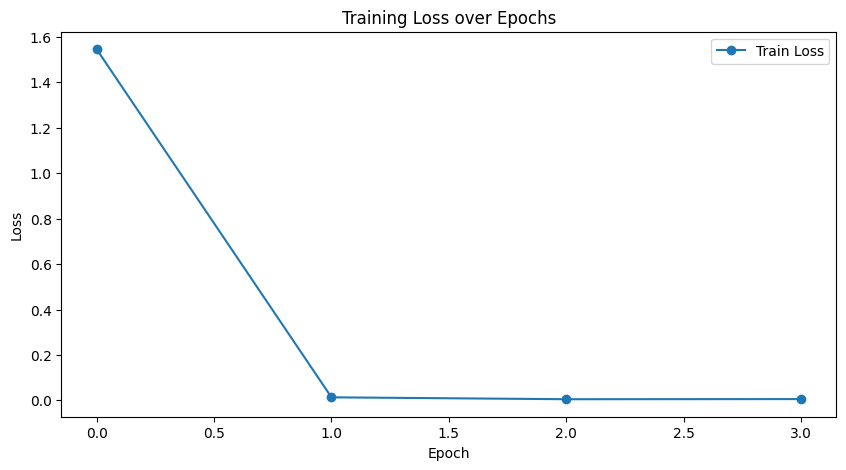

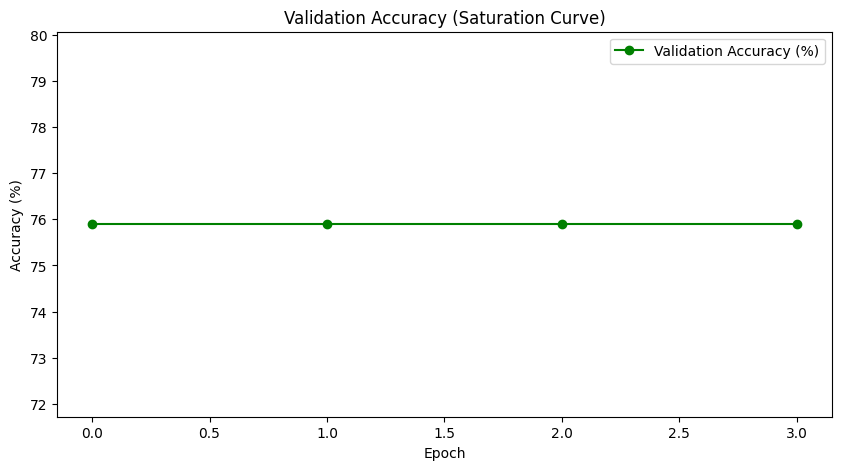

✅ Training complete! Best Validation Accuracy: 75.89%


In [ ]:
# ================================
# FLAN-T5 CLASSIFICATION TRAINING + EARLY STOPPING + GRAPHS
# ================================

!pip install -q transformers torch torchvision sklearn tqdm accelerate matplotlib

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import T5Tokenizer, T5ForConditionalGeneration
from torch.optim import AdamW
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np

# -------- CONFIG --------
MODEL_NAME = "google/flan-t5-base"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 4
EPOCHS = 20
LR = 5e-5
MAX_INPUT_LENGTH = 256
MAX_OUTPUT_LENGTH = 15
PATIENCE = 3  # Early stopping patience

# -------- LOAD DATA --------
train_df = pd.read_csv("train_descriptions.csv")
val_df   = pd.read_csv("val_descriptions.csv")

def create_prompt(row):
    return f"Classify the lesion. ABCDE: Asymmetry-{row['abcde_asymmetry']}, Border-{row['abcde_border']}, Color-{row['abcde_color']}, Diameter-{row['abcde_diameter']}, Evolution-{row['abcde_evolution']}. Features: {row['clinical_features']}.\nAnswer:"

train_texts = train_df.apply(create_prompt, axis=1).tolist()
val_texts   = val_df.apply(create_prompt, axis=1).tolist()

labels = train_df['label'].tolist()
val_labels = val_df['label'].tolist()

# -------- LABEL ENCODING --------
le = LabelEncoder()
le.fit(labels + val_labels)
train_labels_encoded = le.transform(labels)
val_labels_encoded   = le.transform(val_labels)

# -------- TOKENIZER & MODEL --------
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME).to(DEVICE)

# -------- DATASET CLASS --------
class T5ClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        input_ids = enc["input_ids"].squeeze()
        attention_mask = enc["attention_mask"].squeeze()
        label_text = le.inverse_transform([self.labels[idx]])[0]
        labels_enc = self.tokenizer(
            label_text,
            truncation=True,
            padding="max_length",
            max_length=MAX_OUTPUT_LENGTH,
            return_tensors="pt"
        )["input_ids"].squeeze()
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels_enc
        }

# -------- DATALOADERS --------
train_loader = DataLoader(T5ClassificationDataset(train_texts, train_labels_encoded, tokenizer), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(T5ClassificationDataset(val_texts, val_labels_encoded, tokenizer), batch_size=BATCH_SIZE)

# -------- OPTIMIZER --------
optimizer = AdamW(model.parameters(), lr=LR)

# -------- TRAINING WITH EARLY STOPPING --------
train_losses, val_accuracies = [], []
best_val_acc = 0
epochs_no_improve = 0

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # -------- VALIDATION --------
    model.eval()
    val_preds = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=MAX_OUTPUT_LENGTH)
            preds = [tokenizer.decode(ids, skip_special_tokens=True).lower().strip() for ids in outputs]
            val_preds.extend(preds)

    val_labels_text = [le.inverse_transform([l])[0].lower().strip() for l in val_labels_encoded]
    val_acc = accuracy_score(val_labels_text, val_preds)
    val_accuracies.append(val_acc)

    print(f"\nEpoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Validation Accuracy = {val_acc*100:.2f}%")

    # -------- EARLY STOPPING CHECK --------
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_flan_t5.pt")
        print("✅ Model improved and saved.")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s).")
        if epochs_no_improve >= PATIENCE:
            print("⛔ Early stopping triggered.")
            break

# -------- PLOT LOSS & ACCURACY --------
plt.figure(figsize=(10,5))
plt.plot(train_losses, marker='o', label='Train Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(np.array(val_accuracies)*100, marker='o', color='green', label='Validation Accuracy (%)')
plt.title('Validation Accuracy (Saturation Curve)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

print(f"✅ Training complete! Best Validation Accuracy: {best_val_acc*100:.2f}%")


In [ ]:
def __getitem__(self, idx):
    row = self.df.iloc[idx]

    # ✅ Build the same kind of prompt text as used in training
    input_text = (
        f"Classify the lesion. "
        f"ABCDE: Asymmetry-{row['abcde_asymmetry']}, "
        f"Border-{row['abcde_border']}, "
        f"Color-{row['abcde_color']}, "
        f"Diameter-{row['abcde_diameter']}, "
        f"Evolution-{row['abcde_evolution']}. "
        f"Features: {row['clinical_features']}.\nAnswer:"
    )

    # ✅ Label is just the class name
    target_text = str(row["label"])

    # Tokenize input and output
    enc = self.tokenizer(
        input_text,
        truncation=True,
        padding="max_length",
        max_length=self.max_len,
        return_tensors="pt"
    )
    dec = self.tokenizer(
        target_text,
        truncation=True,
        padding="max_length",
        max_length=MAX_OUTPUT_LENGTH,
        return_tensors="pt"
    )

    return {
        "input_ids": enc["input_ids"].squeeze(),
        "attention_mask": enc["attention_mask"].squeeze(),
        "labels": dec["input_ids"].squeeze(),
        "raw_input": input_text,      # optional (to debug later)
        "raw_label": target_text      # optional
    }


In [ ]:
# ================================
# EVALUATION / PREDICTION PHASE
# ================================

import torch
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score
import pandas as pd

# Load validation data again
val_df = pd.read_csv("val_descriptions.csv")

# ✅ Use the SAME PROMPT FUNCTION as training
def create_prompt(row):
    return f"Classify the lesion. ABCDE: Asymmetry-{row['abcde_asymmetry']}, Border-{row['abcde_border']}, Color-{row['abcde_color']}, Diameter-{row['abcde_diameter']}, Evolution-{row['abcde_evolution']}. Features: {row['clinical_features']}.\nAnswer:"

val_texts = val_df.apply(create_prompt, axis=1).tolist()
val_labels = val_df["label"].tolist()

# Encode labels
val_labels_encoded = le.transform(val_labels)

# Reload best model
model.load_state_dict(torch.load("best_flan_t5.pt", map_location=DEVICE))
model.eval()

# Generate predictions
preds = []
for text in tqdm(val_texts, desc="Generating predictions"):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(DEVICE)
    output = model.generate(**inputs, max_length=MAX_OUTPUT_LENGTH)
    pred = tokenizer.decode(output[0], skip_special_tokens=True).lower().strip()
    preds.append(pred)

# Decode true labels
true_labels = [le.inverse_transform([l])[0].lower().strip() for l in val_labels_encoded]

# Calculate accuracy
val_acc = accuracy_score(true_labels, preds)
print(f"\n✅ Final Evaluation Accuracy: {val_acc*100:.2f}%")

# Optional: see few predictions
for i in range(5):
    print(f"\n🔹Prompt: {val_texts[i]}")
    print(f"🔸Predicted: {preds[i]}")
    print(f"🔸Actual: {true_labels[i]}")


Generating predictions:   0%|          | 0/336 [00:00<?, ?it/s]


✅ Final Evaluation Accuracy: 75.89%

🔹Prompt: Classify the lesion. ABCDE: Asymmetry-Pronounced asymmetry - one half distinctly different from the other, Border-Irregular, notched, scalloped, or poorly defined borders, Color-Multiple colors: black, brown, tan, red, white, blue, or depigmented areas, Diameter-Often greater than 6mm (pencil eraser), but can be smaller, Evolution-Changing size, shape, color, or symptoms (itching, bleeding). Features: markedly asymmetric configuration | irregular, notched borders with geographic appearance | striking color variation within single lesion | may show regression (white areas) or inflammation (red areas) | surface may be ulcerated or bleeding in advanced cases.
Answer:
🔸Predicted: melanoma
🔸Actual: melanoma

🔹Prompt: Classify the lesion. ABCDE: Asymmetry-Symmetric - mirror image on both halves, Border-Regular, smooth, well-circumscribed borders, Color-Uniform color - single shade of tan, brown, or black, Diameter-Stable size, typically less tha

In [ ]:


fuzzy_acc = fuzzy_accuracy(true_labels, preds)
print(f"✅ Fuzzy Accuracy (≥85% match): {fuzzy_acc*100:.2f}%")


✅ Fuzzy Accuracy (≥85% match): 100.00%


In [ ]:
!pip install rapidfuzz
from rapidfuzz import fuzz

def fuzzy_accuracy(y_true, y_pred, threshold=85):
    correct = 0
    for t, p in zip(y_true, y_pred):
        score = fuzz.ratio(t, p)
        if score >= threshold:  # e.g., ≥85% similarity
            correct += 1
    return correct / len(y_true)

fuzzy_acc = fuzzy_accuracy(true_labels, preds)
print(f"✅ Fuzzy Accuracy (≥85% match): {fuzzy_acc*100:.2f}%")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 106.4 MB/s eta 0:00:00
✅ Fuzzy Accuracy (≥85% match): 100.00%


In [ ]:
df


NameError: name 'df' is not defined